In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import scprep
import numpy as np

In [2]:
res_dir = '../results_Mar4'
adata = sc.read_h5ad('../data/rna_figure_ready.h5ad')
filtered_bc = np.load(f'{res_dir}/day0_filtered_barcodes.npy', allow_pickle=True)
adata_filtered = adata[filtered_bc,:]

In [3]:
sc.pp.log1p(adata_filtered)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:405: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [4]:
genes_to_plot = ['EPCAM', 'CAV1', 'MMP7', 'VCAN', 'ANXA5', 'CD44']

# Check if each gene is in adata_filtered.var_names
for gene in genes_to_plot:
    assert gene in adata_filtered.var_names, f"Gene {gene} not found in dataset"

In [5]:
# from sklearn.cluster import KMeans

# # Cluster the PHATE embedding into 2 clusters
# kmeans = KMeans(n_clusters=2, random_state=42)
# adata_filtered.obs['kmeans_cluster'] = kmeans.fit_predict(adata_filtered.obsm['X_phate'])
# adata_filtered_0 = adata_filtered[adata_filtered.obs['kmeans_cluster'] == 0]
adata_filtered_0 = adata_filtered
adata_filtered_0 = adata_filtered_0[adata_filtered_0.obs['louvain'] == '5']

In [6]:
import magic
magic_op = magic.MAGIC(random_state=42)
magic_op.fit(adata_filtered_0.obsm['X_pca'])

Running MAGIC on 1582 cells and 50 genes.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.14 seconds.
  Calculating affinities...
  Calculated affinities in 0.15 seconds.
Calculated graph and diffusion operator in 0.30 seconds.


MAGIC(knn_max=15, random_state=42)

Calculating imputation...


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


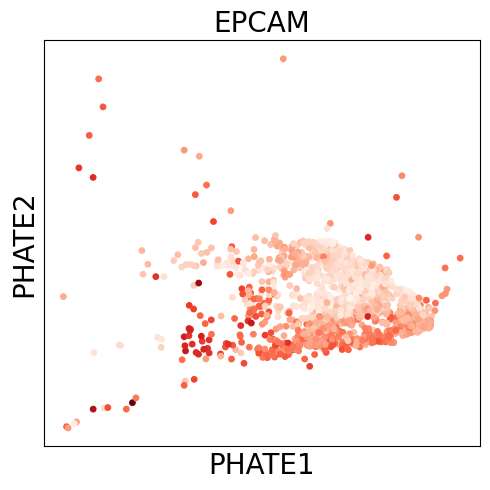

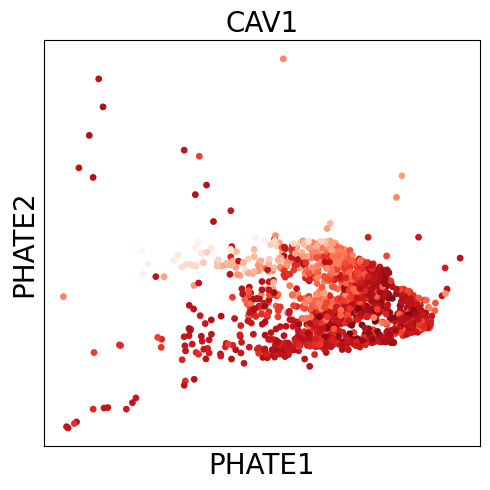

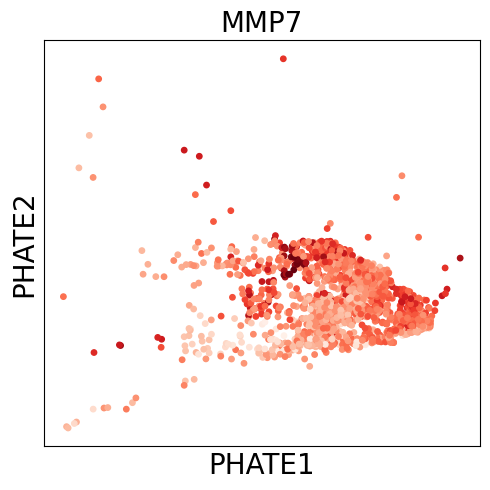

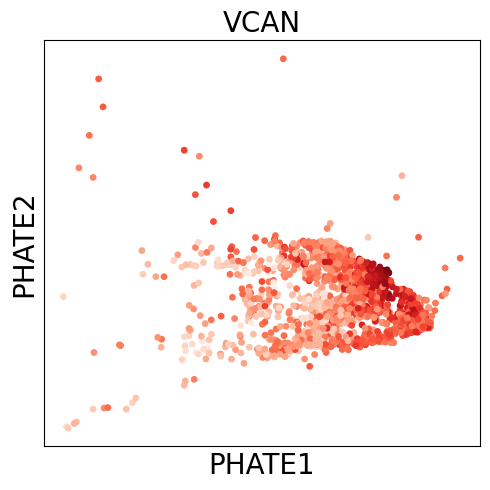

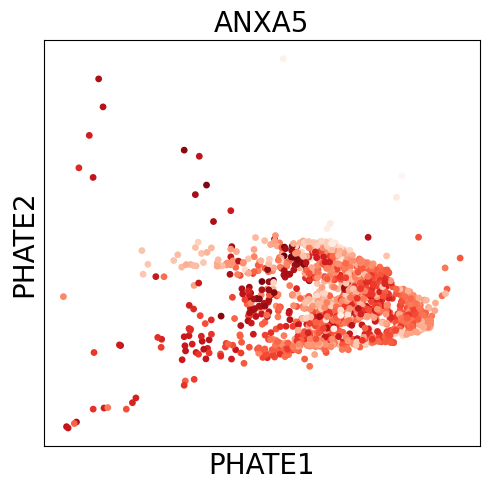

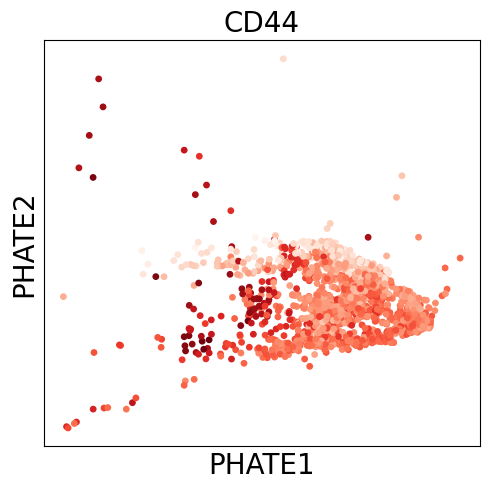

In [9]:
denoised_expr = magic_op.transform(adata_filtered_0[:,genes_to_plot].to_df().apply(np.log1p))
for gene in genes_to_plot:
    plt.figure(figsize=(5, 5))
    plt.scatter(adata_filtered_0.obsm['X_phate'][:,0], adata_filtered_0.obsm['X_phate'][:,1], c=denoised_expr[gene].values, cmap='Reds', s=15)
    plt.tick_params(left=False, bottom=False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('PHATE1', fontsize=20)
    plt.ylabel('PHATE2', fontsize=20)
    plt.title(gene, fontsize=20)
    plt.tight_layout()
    plt.show()

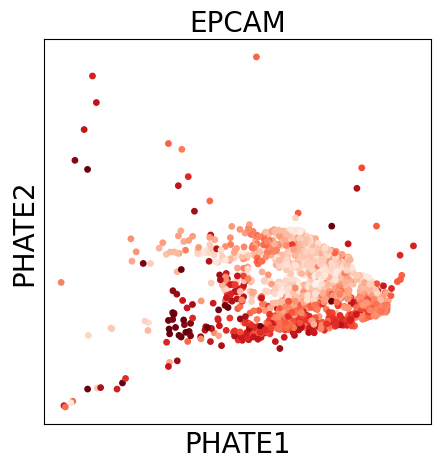

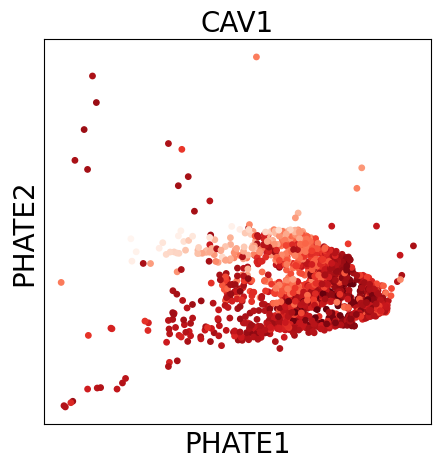

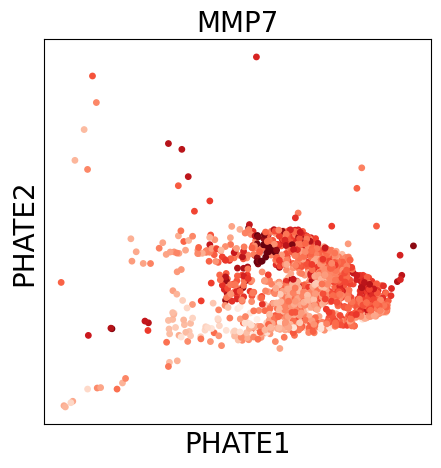

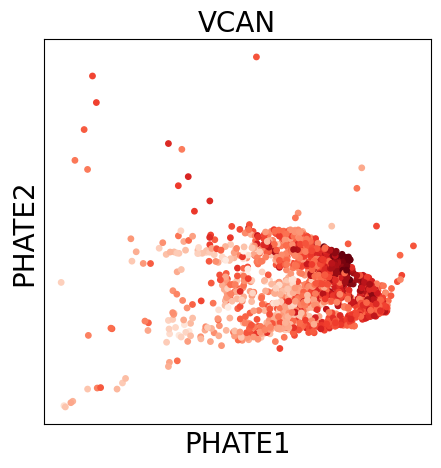

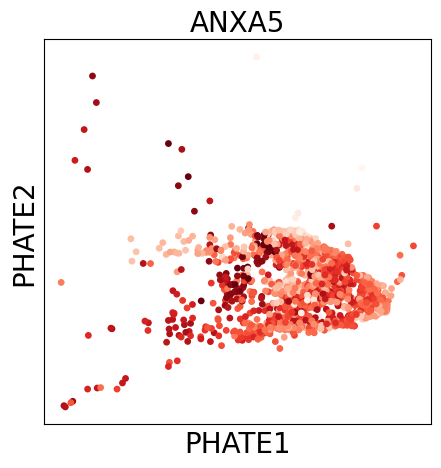

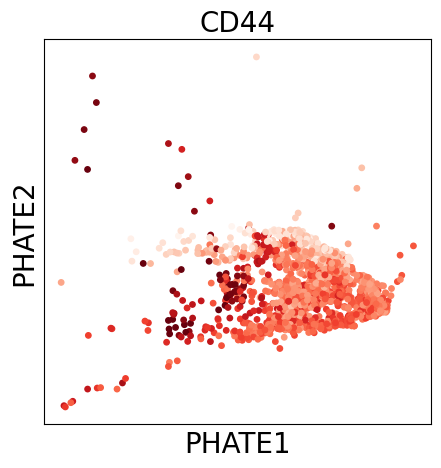

In [10]:
for gene in genes_to_plot:
    plt.figure(figsize=(5, 5))
    # Get gene expression values
    gene_expr = denoised_expr[gene].values
    
    # Calculate 98th percentile threshold for clipping outliers
    threshold = np.percentile(gene_expr, 99)
    
    # Clip values above the threshold instead of dropping them
    clipped_expr = np.clip(gene_expr, None, threshold)
    
    # Plot all points with clipped expression values
    plt.scatter(
        adata_filtered_0.obsm['X_phate'][:, 0], 
        adata_filtered_0.obsm['X_phate'][:, 1], 
        c=clipped_expr, 
        cmap='Reds', 
        s=15
    )
    plt.tick_params(left=False, bottom=False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('PHATE1', fontsize=20)
    plt.ylabel('PHATE2', fontsize=20)
    plt.title(f"{gene}", fontsize=20)
    plt.savefig(f'{res_dir}/day0_phate_denoised_{gene}.pdf', dpi=300, transparent=True)
    # plt.show()